## IRFinder: assessing the impact of intron retention on mammalian gene expression.
### Genome Biol. 2017 Mar 15;18(1):51. doi: 10.1186/s13059-017-1184-4.

URL: https://www.ncbi.nlm.nih.gov/pubmed/28298237

### DataSets

* Simulated dataset: data/IRFinder_GenBio_2017_18_51

In [12]:
# Set the environment variables to be used during the project 

import os
import re
import xmltodict
import warnings
import pandas
import json
import math
import numpy as np
import scipy.stats as stats

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec

from six.moves import cPickle as pickle
from statsmodels.stats.multitest import fdrcorrection_twostage
from pandas import read_csv

warnings.filterwarnings('error')

from Bio import Entrez
Entrez.email = "r78v10a07@gmail.com"

###############################################################
#
#    Update this path
#
###############################################################
os.environ['WORKDIR'] = os.path.abspath('/panfs/pan1.be-md.ncbi.nlm.nih.gov/alt_splicing/bioNotebook-DiffExpIR')
###############################################################

os.environ['CONFIG'] = os.environ['WORKDIR'] + '/config'
os.environ['DATA'] = os.environ['WORKDIR'] + '/data'
os.environ['BIN'] = os.environ['WORKDIR'] + '/bin'
os.environ['RESULTS'] = os.environ['WORKDIR'] + '/results'
os.environ['DOC'] = os.environ['WORKDIR'] + '/docs'
os.environ['SRC'] = os.environ['WORKDIR'] + '/src'

os.environ['DATADIR'] = 'IRFinder_GenBio_2017_18_51'

## Processing the simulated data with STAR

In [8]:
%%bash

mkdir -p ${RESULTS}/${DATADIR}
cd ${RESULTS}/${DATADIR}
if [ ! -e "STAR_hg19_Human" ]
then
    mkdir STAR_hg19_Human
    cd STAR_hg19_Human
    for f in ${DATA}/${DATADIR}/simulated_BAM/*.1.fq
    do
        n=`basename $f`
        n=${n%.1.fq}
        mkdir $n
        cd $n
        $BIN/STAR --runThreadN 4 --genomeDir $DATA/hg19/STAR --outSAMtype BAM Unsorted --outStd BAM_Unsorted --readFilesIn $f ${DATA}/${DATADIR}/simulated_BAM/${n}.2.fq  > ${n}.bam
        samtools flagstat ${n}.bam > ${n}.stats
        samtools sort --threads 4 -o ${n}_sorted.bam ${n}.bam
        samtools index ${n}_sorted.bam ${n}_sorted.bam.bai
        mv ${n}_sorted.bam ${n}.stats ${n}_sorted.bam.bai ../
        cd ..
        rm -rf $n
    done
fi

## Processing alignments with the TPMCalculator

In [10]:
%%bash

cd ${RESULTS}/${DATADIR}/STAR_hg19_Human
for a in *.bam
do
    TPMCalculator -g $DATA/hg19/genes.gtf -b $a -p > ${a%.bam}.TPMlog
done

Reading GTF file ... 
Done in 19.3 seconds
Parsing sample: sim1-fake-qual_rep1_sorted 450464 reads processed in 8.74 seconds
Printing results
Total time: 33.16 seconds
Reading GTF file ... 
Done in 18.95 seconds
Parsing sample: sim1-fake-qual_rep2_sorted 406252 reads processed in 8.1 seconds
Printing results
Total time: 32.27 seconds
Reading GTF file ... 
Done in 19.29 seconds
Parsing sample: sim2-fake-qual_rep1_sorted 904722 reads processed in 13.64 seconds
Printing results
Total time: 38.46 seconds
Reading GTF file ... 
Done in 19.17 seconds
Parsing sample: sim2-fake-qual_rep2_sorted 815778 reads processed in 13.18 seconds
Printing results
Total time: 38.02 seconds


## Processing the TPMCalculator with a Python version of the DiffExpIR

In this part, we are processing the data using a Python code which shows in a simplified way the algorithm used.

### Creating a list of samples to process

In [13]:
os.chdir(os.environ['RESULTS'] + '/' + os.environ['DATADIR'] + '/STAR_hg19_Human')
samples = {'ctrl' : [], 'treat':[]}
files = [name for root, dirs, files in os.walk('./') for name in files if name.endswith("_genes.ent")]
for f in files:
    n = f.split('-')[0]
    if n == "sim1":
        samples['ctrl'].append(f)
    else:
        samples['treat'].append(f)

### Parsing IRFinder description file

In [14]:
IRdata = pandas.read_excel(os.environ['DATA'] + '/' + os.environ['DATADIR'] + '/README.xlsx')
IRdata.head()

,Chromosome,Start,End,Name,Positive/Negative Control,Detection
0,1,1271896.0,1273356.0,dvl1_intron_1,T,"MISO,DEXSeq,IRFinder"
1,1,1273564.0,1273648.0,dvl1_intron_2,FS,NaN
2,1,1273817.0,1273901.0,dvl1_intron_3,T,NaN
3,1,1274034.0,1274741.0,dvl1_intron_4,FR,DEXSeq
4,1,1274820.0,1274961.0,dvl1_intron_5,T,"DEXSeq,IRFinder"


### Function to parser the TPMCalculator data files

In [15]:
def extract_data(ctrl_dir, ctl_samples, treat_dir, treat_samples):
    samples = {}
    for file in ctl_samples:
        print("Parsing file %s" % os.path.join(ctrl_dir, file))
        data = pandas.read_csv(os.path.join(ctrl_dir, file), sep='\t')
        for chr in data.Chr.unique():
            if '_' not in chr:
                if chr not in samples:
                    samples[chr] = {}
                for g in data.loc[data['Chr'] == chr, 'Gene_Id'].unique():
                    if g not in samples[chr]:
                        samples[chr][g] = {}
        for index, row in data.iterrows():
            chr = row['Chr']
            if '_' not in chr:
                g = row['Gene_Id']
                c = int(row['Type_Number'])
                start = int(row['start']) + 1
                end = int(row['end']) + 1
                if c not in samples[chr][g]:
                    samples[chr][g][c] = {'type': row['Type'], 'start': start, 'end': end,
                                          'TPM_list_ctrl': [], 'Reads_list_ctrl': [], 'TPM_ctrl': 0,
                                          'Reads_ctrl': 0,
                                          'TPM_list_treat': [], 'Reads_list_treat': [], 'TPM_treat': 0,
                                          'Reads_treat': 0}
                tpm = float(row['TPM'])
                if tpm < 10E-5:
                    tpm = 10E-5
                samples[chr][g][c]['TPM_list_ctrl'].append(tpm)
                samples[chr][g][c]['Reads_list_ctrl'].append(int(row['Count_Reads']))
                samples[chr][g][c]['TPM_ctrl'] = np.mean(samples[chr][g][c]['TPM_list_ctrl'])
                samples[chr][g][c]['Reads_ctrl'] = np.mean(samples[chr][g][c]['Reads_list_ctrl'])
    for file in treat_samples:
        print("Parsing file %s" % os.path.join(treat_dir, file))
        data = pandas.read_csv(os.path.join(treat_dir, file), sep='\t')
        for chr in data.Chr.unique():
            if '_' not in chr:
                if chr not in samples:
                    samples[chr] = {}
                for g in data.loc[data['Chr'] == chr, 'Gene_Id'].unique():
                    if g not in samples[chr]:
                        samples[chr][g] = {}
        for index, row in data.iterrows():
            chr = row['Chr']
            if '_' not in chr:
                g = row['Gene_Id']
                c = int(row['Type_Number'])
                start = int(row['start']) + 1
                end = int(row['end']) + 1
                if c not in samples[chr][g]:
                    samples[chr][g][c] = {'type': row['Type'], 'start': start, 'end': end,
                                          'TPM_list_ctrl': [], 'Reads_list_ctrl': [], 'TPM_ctrl': 0,
                                          'Reads_ctrl': 0,
                                          'TPM_list_treat': [], 'Reads_list_treat': [], 'TPM_treat': 0,
                                          'Reads_treat': 0}
                tpm = float(row['TPM'])
                if tpm < 10E-5:
                    tpm = 10E-5
                samples[chr][g][c]['TPM_list_treat'].append(tpm)
                samples[chr][g][c]['Reads_list_treat'].append(int(row['Count_Reads']))
                samples[chr][g][c]['TPM_treat'] = np.mean(samples[chr][g][c]['TPM_list_treat'])
                samples[chr][g][c]['Reads_treat'] = np.mean(samples[chr][g][c]['Reads_list_treat'])
    return samples

### Creating a pickle file to store the Python objects used by the DiffExpIR algorithm

In [16]:
os.chdir(os.environ['RESULTS'] + '/' + os.environ['DATADIR'] + '/STAR_hg19_Human')
pickle_file = 'samples_data.pickle'
if not os.path.exists(pickle_file):    
    try:
        samples_data = extract_data('./', samples['ctrl'], './', samples['treat'])
        print('Pickling ...')    
        with open(pickle_file, 'wb') as f:
            pickle.dump(samples_data, f, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
else:
    try:
        print('Reading data for the ttest')
        with open(pickle_file, 'rb') as f:
            s_data_ttest = pickle.load(f)
        print('Reading data for the Mann Whitney')
        with open(pickle_file, 'rb') as f:
            s_data_mannwhitneyu = pickle.load(f)
        print('Reading data for the ttest with log values')
        with open(pickle_file, 'rb') as f:
            s_data_ttest_log = pickle.load(f)
        print('Reading data for the Mann Whitney with log values')
        with open(pickle_file, 'rb') as f:
            s_data_mannwhitneyu_log = pickle.load(f)
    except Exception as e:
        print('Unable to process data from', pickle_file, ':', e)
        raise

Parsing file ./sim1-fake-qual_rep1_sorted_genes.ent
Parsing file ./sim1-fake-qual_rep2_sorted_genes.ent
Parsing file ./sim2-fake-qual_rep1_sorted_genes.ent
Parsing file ./sim2-fake-qual_rep2_sorted_genes.ent
Pickling ...


### Function to process one intron in a gene

This function executes the T-Test function to calculate the P-Value associated to the comparison among the control and treated samples. 

Then, the r values, $r = log_{2}\lgroup\frac{TPM^{intron}_i}{(TPM^{exon}_{i-1} + TPM^{exon}_{i+1})}\rgroup$, is calculated.

This function returns for the intron: PValue, $-1.0 * log_{10}(PValue)$, $r_{ctrl}$, $r_{treat}$, $log_{2}\lgroup\frac{TPM^{intron}_{treat}}{TPM^{intron}_{ctrl}}\rgroup$


In [17]:
def process_one(chr, g, a, samples, method, useLog10 = False):
    equal_var = False
    if len(samples[chr][g][a]['TPM_list_treat']) == len(samples[chr][g][a]['TPM_list_ctrl']):
        equal_var = True
    treat = []
    ctrl = []
    if useLog10:
        for i in samples[chr][g][a]['TPM_list_treat']:            
            treat.append(math.log10(i))
        for i in samples[chr][g][a]['TPM_list_ctrl']:
            ctrl.append(math.log10(i))
    else:
        treat = samples[chr][g][a]['TPM_list_treat']
        ctrl = samples[chr][g][a]['TPM_list_ctrl']
    if method == 'ttest':
        t, p = stats.ttest_ind(treat, ctrl, equal_var=equal_var)
    elif method == 'mannwhitneyu':
        t, p = stats.mannwhitneyu(treat, ctrl)
    else:
        print('Error. Method should be ttest or mannwhitneyu')
        return
    c = a - 1
    e11 = 0.0
    e21 = 0.0
    e12 = 0.0
    e22 = 0.0
    while c != 0:
        if samples[chr][g][c]['type'] == 'exon':
            e11 = samples[chr][g][c]['TPM_ctrl']
            e21 = samples[chr][g][c]['TPM_treat']
            break
        c -= 1
    c = a + 1
    while c < len(samples[chr][g]):
        if samples[chr][g][c]['type'] == 'exon':
            e12 = samples[chr][g][c]['TPM_ctrl']
            e22 = samples[chr][g][c]['TPM_treat']
            break
        c += 1
    samples[chr][g][a]['p'] = p
    minuslog10p = -1.0 * math.log10(p)
    r1 = math.log2(samples[chr][g][a]['TPM_ctrl'] / (e11 + e12))
    r2 = math.log2(samples[chr][g][a]['TPM_treat'] / (e21 + e22))    
    log2TPMRatio = math.log2(samples[chr][g][a]['TPM_treat']/samples[chr][g][a]['TPM_ctrl'])
    return p, minuslog10p, r1, r2, log2TPMRatio

### Function to process all data

This function process all genes with all introns. The results are inserted into the "samples" dictionary.

In [18]:
def process_sample(samples, method, useLog10 = False):   
    count = 0
    for chr in samples:
        for g in samples[chr]:
            for a in samples[chr][g]:
                if samples[chr][g][a]['type'] == 'intron':
                    try:
                        p, minuslog10p, r1, r2, log2TPMRatio = process_one(chr, g, a, samples, method, useLog10)
                        samples[chr][g][a]['p'] = p
                        samples[chr][g][a]['minuslog10p'] = minuslog10p
                        samples[chr][g][a]['r1'] = r1
                        samples[chr][g][a]['r2'] = r2
                        samples[chr][g][a]['log2TPMRatio'] = log2TPMRatio
                    except:
                        pass
    return samples

### Function to create the arrays to be ploted with colors

This function return tree arrays x, y, c. The arrays x and y are the points to be plotted. x is $log_{2}\lgroup\frac{TPM^{intron}_{treat}}{TPM^{intron}_{ctrl}}\rgroup$ and y is $-1.0 * log_{10}(PValue)$. c is an array of colors with red for statistically relevant points and black for the non relevants.

In [19]:
def process_plot(samples, r, p):
    x_intron = []
    y_intron = []
    c_intron = []
    for chr in samples:
        for g in samples[chr]:
            for a in samples[chr][g]:
                if samples[chr][g][a]['type'] == 'intron' and 'r1' in samples[chr][g][a]:
                    if samples[chr][g][a]['r1'] > r or samples[chr][g][a]['r2'] > r:
                        y_intron.append(samples[chr][g][a]['minuslog10p'])
                        x_intron.append(samples[chr][g][a]['log2TPMRatio'])
                        if abs(samples[chr][g][a]['log2TPMRatio']) > 2 and samples[chr][g][a]['p'] < p:
                            c_intron.append('red')
                        else:
                            c_intron.append('black')                    
    return x_intron, y_intron, c_intron    

### Printing the selected data

In [20]:
def print_process_plot(samples, r, p, filename):
    count = 0
    with open(filename, 'w') as f_out:
        for chr in samples:
            for g in samples[chr]:
                for a in samples[chr][g]:
                    if samples[chr][g][a]['type'] == 'intron' and 'minuslog10p' in samples[chr][g][a]:
                        if abs(samples[chr][g][a]['log2TPMRatio']) > 2 and samples[chr][g][a]['p'] < p and (samples[chr][g][a]['r1'] > r or samples[chr][g][a]['r2'] > r):
                            count += 1
                            f_out.write(
                                g + '\t' 
                                + chr + ':' + str(samples[chr][g][a]['start']) + '-' + str(samples[chr][g][a]['end'])
                                + '\t' + str(samples[chr][g][a]['p'])
                                + '\t' + str(samples[chr][g][a]['minuslog10p'])
                                + '\t' + str(samples[chr][g][a]['TPM_ctrl'])
                                + '\t' + str(samples[chr][g][a]['TPM_treat'])                            
                                + '\t' + str(samples[chr][g][a]['log2TPMRatio'])
                                + '\t' + str(samples[chr][g][a]['r1'])
                                + '\t' + str(samples[chr][g][a]['r2'])
                                + '\n')
    return count

### Processing data with the Ttest

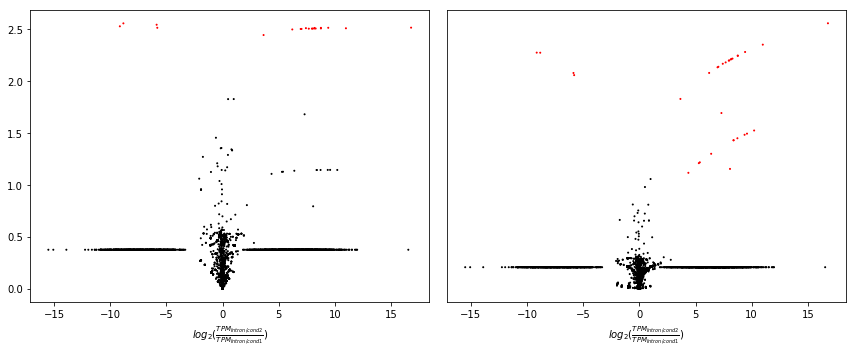

In [25]:
plt.figure(figsize=(12, 5)) 
gs = gridspec.GridSpec(1, 2) 

plt.subplot(gs[0])
s_data_ttest = process_sample(s_data_ttest, 'ttest')
count = print_process_plot(s_data_ttest, -1.0, 0.01, 'diff_exp_intron_retained_ttest.txt')
x_intron, y_intron, c_intron = process_plot(s_data_ttest, -1.0, 0.01)
plt.xlabel(r'$log_{2}(\frac{TPM_{Intron/cond2}}{TPM_{Intron/cond1}})$')
plt.scatter(x_intron, y_intron, s=1, c=c_intron)

plt.subplot(gs[1])
s_data_ttest_log = process_sample(s_data_ttest_log, 'ttest', True)
count = print_process_plot(s_data_ttest_log, -1.0, 0.01, 'diff_exp_intron_retained_ttest_log10.txt')
x_intron, y_intron, c_intron = process_plot(s_data_ttest_log, -1.0, 0.01)
plt.yticks([])
plt.xlabel(r'$log_{2}(\frac{TPM_{Intron/cond2}}{TPM_{Intron/cond1}})$')
plt.scatter(x_intron, y_intron, s=1, c=c_intron)

plt.tight_layout()
plt.show()

## Processing the DiffExpIR (C++ version) output

In this part, we will process the results obtained from the C++ code and compare it with the Python version and the IRFinder results.

In [13]:
diffData = pandas.read_csv(os.environ['RESULTS'] + '/' + os.environ['DATADIR'] + '/STAR_hg19_Human/diffexpir.tsv', sep="\t")
diffData.head()

,GeneId,Chr,Start,End,Intron_Start,Intron_End,Log2TPMRatio,TPM_1,TPM_2,minusLog10PValue,PValue,RValue_1,RValue_2
0,WASH7P,chr1,14362,29370,17437,17605,-0.080498,28.14420,29.75920,1.34240,0.045456,-2.64540,-2.53817
1,CPSF3L,chr1,1246965,1260067,1248330,1248414,1.444110,8.97204,3.29739,1.49069,0.032308,-4.80417,-6.12529
2,CPSF3L,chr1,1246965,1260067,1255910,1256375,-0.153285,52.19680,58.04810,2.06348,0.008640,-3.23291,-3.27659
3,DVL1,chr1,1270658,1284492,1273817,1273901,-18.639400,0.00010,40.83370,1.68797,0.020513,-20.30730,-2.07316
4,DVL1,chr1,1270658,1284492,1274034,1274741,-2.967360,1.12058,8.76406,2.13422,0.007341,-7.43678,-5.10937


In [14]:
def process_plot_diffexpir(data, r, p):
    x_intron = []
    y_intron = []
    c_intron = []
    for index, row in data.iterrows(): 
        if row['RValue_1'] > r or row['RValue_2'] > r:
            y_intron.append(row['minusLog10PValue'])
            x_intron.append(row['Log2TPMRatio'])
            if abs(row['Log2TPMRatio']) > 2 and row['PValue'] < p:
                c_intron.append('red')
            else:
                c_intron.append('black')                        
    return x_intron, y_intron, c_intron    

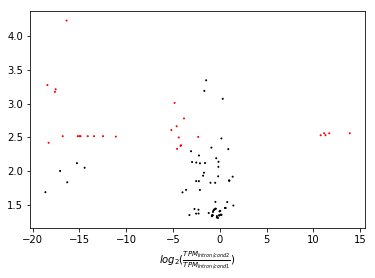

In [15]:
x_intron, y_intron, c_intron = process_plot_diffexpir(diffData, -100.0, 0.005)
plt.xlabel(r'$log_{2}(\frac{TPM_{Intron/cond2}}{TPM_{Intron/cond1}})$')
plt.scatter(x_intron, y_intron, s=1, c=c_intron)
plt.show()